# 1.1 Autoencoders

In this tutorial we will familiarize ourselves with Autoencoders (AEs) and how they work in practice. AEs are the common encoder-decoder architecture, where the input is projected into a lower dimensional (latent) space, which is then fully reconstructed. The latent space is learned with the aim to capture similarities between the inputs and can be used for dimensionality reduction.

In [1]:
import os
import math
from typing import Tuple

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.distributions import Normal

torch.manual_seed(0);

## Data

We will be experimenting with the popular MNIST dataset provided by `torchvision`. It contains 60 000, 28x28 grayscale images of handwritten digits. We can download it directly as follows:

In [2]:
mnist = MNIST('data', transform=ToTensor(), download=True)
dataloader = DataLoader(mnist, batch_size=100, shuffle=True)
len(mnist)

60000

Here to each sample we apply the `ToTensor()` transformation, which simply scales the input between 0 and 1 and converts the images to pytorch tensors. Since we don't have enough memory to pass the entire dataset into our model, we will use batches of size 100, utilizing the `DataLoader` from pytorch. The following shows an example image from the dataset.

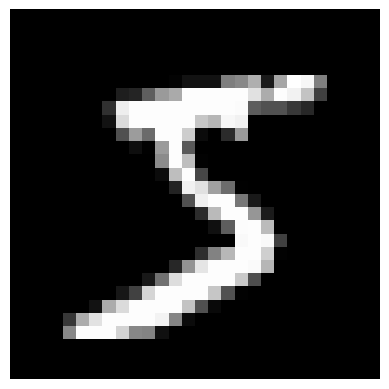

In [3]:
def show_image(idx: int) -> None:
    image = mnist[idx][0].squeeze()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

show_image(0)

## AE

We can define our autoencoder. The encoder is a compression function $\textbf{z}=encoder(\textbf{x})$, mapping the data $\textbf{x}  \in \mathbb{R}^d \to \textbf{z} \in \mathbb{R}^p$. The reconstructed representation is reconstructed to $\hat{\textbf{x}}$ by the decoder 

The encoder and decoder are regular feed forward neural networks. Our latent space will consist of $p$ distributions. We will be using $p=2$ in order to visualize the latent space later. Notice that this is a reduction of 99.75% (a 784-dimensional feature vector is reduced to only 2 numbers) so we cannot expect super impressive results.

In [4]:
class CustomAE(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        z = self.encoder(x)
        return z
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        x = self.decoder(z)
        return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        z = self.encode(x)
        reconstruction = self.decode(z)
        return reconstruction
    
ae = CustomAE()
optimizer = torch.optim.Adam(params=ae.parameters())

### Training
Now we can get to training our model! Feel free to reduce the number of epochs or the size of the model. After training, the model weights will be saved at `custom_ae.pt` (~ 3MB) to make sure that you do not need to retrain the model every time you restart the notebook.

In [5]:
model_path = 'custom_ae.pt'
if os.path.exists(model_path):
    ae.load_state_dict(torch.load(model_path, weights_only=True))
else:
    epochs = 15
    for epoch in range(epochs):
        ae.train()
        train_loss = 0
        for batch_idx, (x, _) in tqdm(enumerate(dataloader)):
            x = x.flatten(1) # transform (batch_size, 1, 28, 28) to (batch_size, 784)
            optimizer.zero_grad()
            reconstruction= ae(x)
            loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset):.4f}")
    torch.save(ae.state_dict(), model_path)

### Evaluation

We can see that our model is definitely learning! Let's visualize a reconstruction of a training sample:

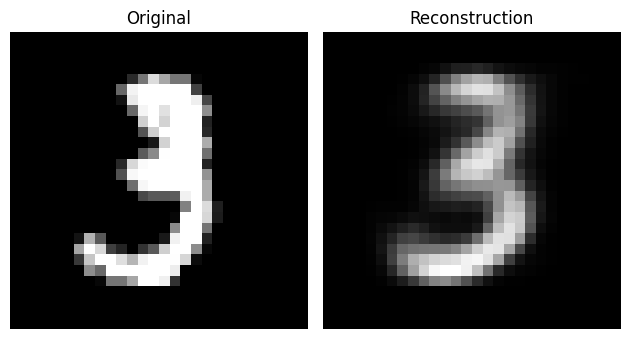

In [6]:
def reconstruct_image(idx: int = 0) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    image = mnist[idx][0].flatten(1)
    with torch.inference_mode():
        reconstruction= ae(image)
    return image.squeeze().reshape(28, 28), reconstruction.squeeze().reshape(28, 28)

def show_reconstruction(original_image: torch.Tensor, reconstruction: torch.Tensor) -> None:
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(original_image, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Original')
    ax[1].imshow(reconstruction, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Reconstruction')
    plt.tight_layout()
    plt.show()

idx = 10
original, reconstruction = reconstruct_image(idx)
show_reconstruction(original, reconstruction)

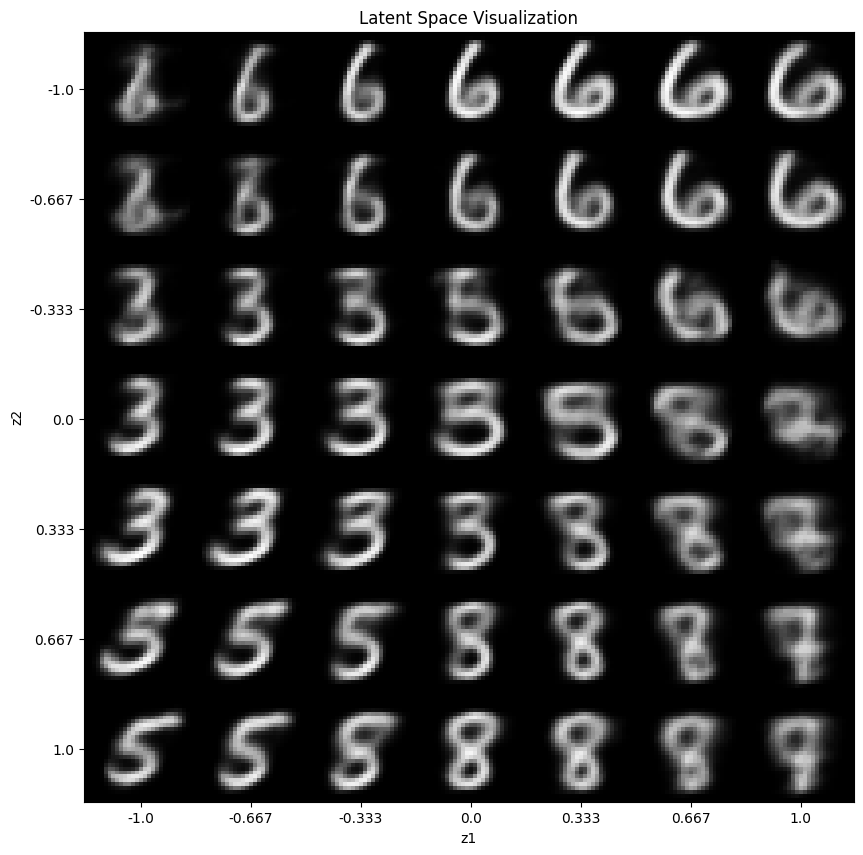

In [7]:
def visualize_latent_space():
    # How many images to show per row and column
    rows, cols = 7, 7

    # Samples of the latent space
    xs = torch.linspace(-1, 1, cols)
    ys = torch.linspace(-1, 1, rows)
    samples = torch.stack([torch.stack((x, y)) for x in xs for y in ys])
    
    # Calculate the reconstructions
    with torch.inference_mode():
        images = ae.decode(samples).reshape(rows, cols, 28, 28)

    # Concatenate all reconstructions into a grid
    grid = torch.cat([torch.cat([images[i, j] for i in range(rows)], dim=1) for j in range(cols)], dim=0)
    
    # Plot them
    fig = plt.figure(figsize=(10,10))
    xticks, yticks = range(14, (cols) * 28 + 14, 28), range(14, (rows) * 28 + 14, 28)
    xlabels, ylabels = xs.round(decimals=3).numpy(), ys.round(decimals=3).numpy()
    plt.xticks(ticks=xticks, labels=xlabels)
    plt.yticks(ticks=yticks, labels=ylabels)
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.imshow(grid,cmap='gray')
    plt.title('Latent Space Visualization')
    plt.show()

visualize_latent_space()